In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv
/kaggle/input/states-map/ne_10m_admin_1_states_provinces.shp
/kaggle/input/states-map/ne_10m_admin_1_states_provinces.dbf
/kaggle/input/states-map/ne_10m_admin_1_states_provinces.README.html
/kaggle/input/states-map/ne_10m_admin_1_states_provinces.shx
/kaggle/input/states-map/ne_10m_admin_1_states_provinces.VERSION.txt
/kaggle/input/states-map/ne_10m_admin_1_states_provinces.prj


In [141]:
df_train=pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/train.csv")
df_test=pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/test.csv")
sample_subm=pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv")  
oil=pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/oil.csv")
hol=pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv")
stores=pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/stores.csv")
transact=pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/transactions.csv")
hol = hol.rename(columns={"type": "type_hol"})
stores=stores.rename(columns={'type':'type_store'})


## Combiinig/edditing/adding the data

In [94]:
df_train

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


In [95]:
len(df_train.groupby('date')) 

1684

In [142]:
# drop the last few from the test set andd merge with df_train 
oil=oil[:1206]
oil=oil.rename(columns={"dcoilwtico": "oil"})
combined=pd.merge(df_train,oil,on='date', how='outer')

# There are just 3 days for which we don't  know oil price neither sales
(len(combined)-len(df_train),len(combined))

(3, 3000891)

In [97]:
combined[combined['sales'].isna()]

,id,date,store_nbr,family,sales,onpromotion,oil
637956,NaN,2013-12-25,NaN,NaN,NaN,NaN,NaN
1286605,NaN,2014-12-25,NaN,NaN,NaN,NaN,NaN
1935254,NaN,2015-12-25,NaN,NaN,NaN,NaN,NaN


In [143]:
# merging stores 
combined=pd.merge(combined, stores,on='store_nbr', how='outer')
len(combined)-3000891
# =0 so no duplicates

0

In [99]:
#Adding day/month week
combined['year']=combined['date'].apply(lambda x: x.split('-')[0]).astype(int)
combined['month']=combined['date'].apply(lambda x: x.split('-')[1]).astype(int)
combined['day']=combined['date'].apply(lambda x: x.split('-')[2]).astype(int)


#and day of the week
import calendar
from datetime import date

def date_to_day(year,month,day):
    d = calendar.weekday(year, month, day)
    days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    return days[d]

combined['day_of_the_week']=combined.apply(lambda row: date_to_day(row['year'], row['month'], row['day']), axis=1)
combined['week_number'] = combined.apply(lambda row: date(row['year'], row['month'], row['day']).isocalendar()[1], axis=1)

In [144]:
#merging transactions
combined = combined.merge(
   transact[['date', 'store_nbr', 'transactions']],
    on=['date', 'store_nbr'],
    how='left'
)

In [101]:
len(combined)-3000891
# =0 so no duplicates

0

In [102]:
#Looking for transferred holidays - not many, can deal with it later 
transf=hol[hol.transferred==True]
transf

,date,type_hol,locale,locale_name,description,transferred
19,2012-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
72,2013-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
135,2014-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
255,2016-05-24,Holiday,National,Ecuador,Batalla de Pichincha,True
266,2016-07-25,Holiday,Local,Guayaquil,Fundacion de Guayaquil,True
268,2016-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,True
297,2017-01-01,Holiday,National,Ecuador,Primer dia del ano,True
303,2017-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,True
312,2017-05-24,Holiday,National,Ecuador,Batalla de Pichincha,True
324,2017-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,True


In [103]:
hol = pd.get_dummies(hol, columns=['locale'],prefix='Hol')
#We can adjust weights here or later
hol['Hol_Local']=hol['Hol_Local']*1
hol['Hol_National']=hol['Hol_National']*1
hol['Hol_Regional']=hol['Hol_Regional']*1


In [104]:
# Looking at local holidays
hol_loc=hol[hol['Hol_Local']==1]
hol_loc=hol_loc.rename(columns={'locale_name':'city'})
hol_loc=hol_loc[['date', 'type_hol', 'city', 'description', 'transferred',
       'Hol_Local']]
hol_loc

,date,type_hol,city,description,transferred,Hol_Local
0,2012-03-02,Holiday,Manta,Fundacion de Manta,False,1
2,2012-04-12,Holiday,Cuenca,Fundacion de Cuenca,False,1
3,2012-04-14,Holiday,Libertad,Cantonizacion de Libertad,False,1
4,2012-04-21,Holiday,Riobamba,Cantonizacion de Riobamba,False,1
5,2012-05-12,Holiday,Puyo,Cantonizacion del Puyo,False,1
...,...,...,...,...,...,...
339,2017-12-05,Additional,Quito,Fundacion de Quito-1,False,1
340,2017-12-06,Holiday,Quito,Fundacion de Quito,True,1
341,2017-12-08,Holiday,Loja,Fundacion de Loja,False,1
342,2017-12-08,Transfer,Quito,Traslado Fundacion de Quito,False,1


In [105]:
# Looking at Regional holidays
hol_reg=hol[hol['Hol_Regional']==1]
hol_reg=hol_reg.rename(columns={'locale_name':'state'})
hol_reg=hol_reg[['date', 'type_hol', 'state', 'description', 'transferred',
       'Hol_Regional']]
hol_reg

,date,type_hol,state,description,transferred,Hol_Regional
1,2012-04-01,Holiday,Cotopaxi,Provincializacion de Cotopaxi,False,1
7,2012-06-25,Holiday,Imbabura,Provincializacion de Imbabura,False,1
23,2012-11-06,Holiday,Santo Domingo de los Tsachilas,Provincializacion de Santo Domingo,False,1
24,2012-11-07,Holiday,Santa Elena,Provincializacion Santa Elena,False,1
47,2013-04-01,Holiday,Cotopaxi,Provincializacion de Cotopaxi,False,1
58,2013-06-25,Holiday,Imbabura,Provincializacion de Imbabura,False,1
76,2013-11-06,Holiday,Santo Domingo de los Tsachilas,Provincializacion de Santo Domingo,False,1
77,2013-11-07,Holiday,Santa Elena,Provincializacion Santa Elena,False,1
96,2014-04-01,Holiday,Cotopaxi,Provincializacion de Cotopaxi,False,1
112,2014-06-25,Holiday,Imbabura,Provincializacion de Imbabura,False,1


In [106]:
# Looking at National holidays
hol_nat=hol[hol['Hol_National']==1]
hol_nat=hol_nat[['date', 'type_hol', 'description', 'transferred',
       'Hol_National']]
hol_nat

,date,type_hol,description,transferred,Hol_National
14,2012-08-10,Holiday,Primer Grito de Independencia,False,1
19,2012-10-09,Holiday,Independencia de Guayaquil,True,1
20,2012-10-12,Transfer,Traslado Independencia de Guayaquil,False,1
21,2012-11-02,Holiday,Dia de Difuntos,False,1
22,2012-11-03,Holiday,Independencia de Cuenca,False,1
...,...,...,...,...,...
345,2017-12-22,Additional,Navidad-3,False,1
346,2017-12-23,Additional,Navidad-2,False,1
347,2017-12-24,Additional,Navidad-1,False,1
348,2017-12-25,Holiday,Navidad,False,1


In [107]:
combined['type_hol']=None

In [108]:
# Now merging/mapping national holidays 
 
# Create a mapping of holidays
holiday_nat_map = dict(zip(hol_nat['date'], hol_nat['Hol_National']))
holiday_nat_type_map = dict(zip(hol_nat['date'], hol_nat['type_hol']))
holiday_nat_name_map = dict(zip(hol_nat['date'], hol_nat['description']))
holiday_transf_map = dict(zip(hol_nat['date'], hol_nat['transferred']))
# Assign holidays based on mapping  
combined['hol_Nat'] = combined['date'].map(holiday_nat_map)
combined['transfered'] = combined['date'].map(holiday_transf_map)
combined['hol_Nat_name'] = combined['date'].map(holiday_nat_name_map)
combined.loc[combined['type_hol'].isna(), 'type_hol'] = combined['date'].map(holiday_nat_type_map)

In [109]:
combined.sample(5)

,id,date,store_nbr,family,sales,onpromotion,oil,city,state,type_store,...,year,month,day,day_of_the_week,week_number,transactions,type_hol,hol_Nat,transfered,hol_Nat_name
2845031,587831.0,2013-11-26,52.0,BEAUTY,0.0,0.0,93.41,Manta,Manabi,A,...,2013,11,26,Tuesday,48,NaN,NaN,NaN,NaN,NaN
1867075,1793584.0,2015-10-06,34.0,BABY CARE,0.0,0.0,48.53,Guayaquil,Guayas,B,...,2015,10,6,Tuesday,41,2325.0,NaN,NaN,NaN,NaN
246871,1327291.0,2015-01-17,5.0,SCHOOL AND OFFICE SUPPLIES,0.0,0.0,NaN,Santo Domingo,Santo Domingo de los Tsachilas,D,...,2015,1,17,Saturday,3,1662.0,NaN,NaN,NaN,NaN
1881891,2593701.0,2016-12-30,34.0,AUTOMOTIVE,1.0,0.0,53.75,Guayaquil,Guayas,B,...,2016,12,30,Friday,52,3403.0,NaN,NaN,NaN,NaN
2286528,436020.0,2013-09-02,42.0,MEATS,0.0,0.0,NaN,Cuenca,Azuay,D,...,2013,9,2,Monday,36,NaN,NaN,NaN,NaN,NaN


In [110]:
len( set(hol_nat['date'].unique())- set(combined['date'].unique()))
#so there are 22 holidays that we left - if needed we can add them 

22

In [111]:
# Now merging/mapping local holidays 
holiday_loc_map = dict(zip(zip(hol_loc['date'], hol_loc['city'].str.strip()), hol_loc['Hol_Local']))
holiday_loc_type_map = dict(zip(zip(hol_loc['date'], hol_loc['city'].str.strip()), hol_loc['type_hol']))
holiday_loc_name_map = dict(zip(zip(hol_loc['date'], hol_loc['city'].str.strip()), hol_loc['description']))
holiday_loc_transf_map = dict(zip(zip(hol_loc['date'], hol_loc['city'].str.strip()), hol_loc['transferred']))
combined['hol_Loc'] = combined.apply(lambda row: holiday_loc_map.get((row['date'], row['city'])), axis=1)
combined['transfered'] = combined.apply(lambda row: holiday_loc_map.get((row['date'], row['city'])), axis=1)
combined.loc[combined['type_hol'].isna(), 'type_hol']= combined.loc[combined['type_hol'].isna()].apply(lambda row: holiday_loc_type_map.get((row['date'], row['city'])), axis=1)

combined['hol_loc_name'] = combined.apply(lambda row: holiday_loc_name_map.get((row['date'], row['city'])), axis=1)

In [112]:
combined[combined['hol_loc_name'].notna()].sample(5)

,id,date,store_nbr,family,sales,onpromotion,oil,city,state,type_store,...,day,day_of_the_week,week_number,transactions,type_hol,hol_Nat,transfered,hol_Nat_name,hol_Loc,hol_loc_name
1345463,633191.0,2013-12-22,25.0,LAWN AND GARDEN,5.000,0.0,NaN,Salinas,Santa Elena,D,...,22,Sunday,51,1038.0,Additional,1.0,1.0,Navidad-3,1.0,Cantonizacion de Salinas
1996527,2780904.0,2017-04-14,36.0,PLAYERS AND ELECTRONICS,9.000,0.0,NaN,Libertad,Guayas,E,...,14,Friday,15,1270.0,Holiday,1.0,1.0,Viernes Santo,1.0,Cantonizacion de Libertad
213989,2552930.0,2016-12-06,4.0,HOME APPLIANCES,0.000,0.0,50.95,Quito,Pichincha,D,...,6,Tuesday,49,1499.0,Holiday,NaN,1.0,NaN,1.0,Fundacion de Quito
2603577,2553186.0,2016-12-06,47.0,DELI,875.541,13.0,50.95,Quito,Pichincha,A,...,6,Tuesday,49,4584.0,Holiday,NaN,1.0,NaN,1.0,Fundacion de Quito
1444169,2962301.0,2017-07-25,26.0,MAGAZINES,0.000,0.0,47.77,Guayaquil,Guayas,D,...,25,Tuesday,30,479.0,Additional,NaN,1.0,NaN,1.0,Fundacion de Guayaquil


In [113]:
# We lost 32 local holidays, again we can add them if we need
len(set(hol_loc['date'].unique())- set(combined['date'].unique()))

32

In [114]:
# Now merging/mapping reg holidays 
holiday_reg_map = dict(zip(zip(hol_reg['date'], hol_reg['state'].str.strip()), hol_reg['Hol_Regional']))
holiday_reg_type_map = dict(zip(zip(hol_reg['date'], hol_reg['state'].str.strip()), hol_reg['type_hol']))
holiday_reg_name_map = dict(zip(zip(hol_reg['date'], hol_reg['state'].str.strip()), hol_reg['description']))
combined['hol_Reg'] = combined.apply(lambda row: holiday_reg_map.get((row['date'], row['state'])), axis=1)
combined['hol_Reg_name'] = combined.apply(lambda row: holiday_reg_name_map.get((row['date'], row['state'])), axis=1)
combined.loc[combined['type_hol'].isna(), 'type_hol'] = combined.loc[combined['type_hol'].isna()].apply(lambda row: holiday_reg_type_map.get((row['date'], row['state'])), axis=1)


In [115]:
combined[combined['hol_Reg_name'].notna()].sample(5)

,id,date,store_nbr,family,sales,onpromotion,oil,city,state,type_store,...,week_number,transactions,type_hol,hol_Nat,transfered,hol_Nat_name,hol_Loc,hol_loc_name,hol_Reg,hol_Reg_name
705922,2108257.0,2016-04-01,13.0,LADIESWEAR,8.0,0.0,35.36,Latacunga,Cotopaxi,C,...,13,979.0,Holiday,NaN,NaN,NaN,NaN,None,1.0,Provincializacion de Cotopaxi
1157712,2498799.0,2016-11-06,21.0,CELEBRATION,4.0,0.0,NaN,Santo Domingo,Santo Domingo de los Tsachilas,B,...,44,1323.0,Holiday,NaN,NaN,NaN,NaN,None,1.0,Provincializacion de Santo Domingo
669841,160519.0,2013-04-01,13.0,CLEANING,1059.0,0.0,97.10,Latacunga,Cotopaxi,C,...,14,1125.0,Holiday,NaN,NaN,NaN,NaN,None,1.0,Provincializacion de Cotopaxi
1368001,1850296.0,2015-11-07,25.0,LADIESWEAR,0.0,0.0,NaN,Salinas,Santa Elena,D,...,45,876.0,Holiday,NaN,NaN,NaN,NaN,None,1.0,Provincializacion Santa Elena
614279,160496.0,2013-04-01,12.0,HOME APPLIANCES,0.0,0.0,97.10,Latacunga,Cotopaxi,C,...,14,1313.0,Holiday,NaN,NaN,NaN,NaN,None,1.0,Provincializacion de Cotopaxi


In [116]:
combined[['hol_Nat','hol_Reg','hol_Loc']]=combined[['hol_Nat','hol_Reg','hol_Loc']].fillna(0)


In [127]:
combined[combined['hol_Nat']+combined['hol_Reg']+combined['hol_Loc']>1]

,id,date,store_nbr,family,sales,onpromotion,oil,city,state,type_store,...,week_number,transactions,type_hol,hol_Nat,transfered,hol_Nat_name,hol_Loc,hol_loc_name,hol_Reg,hol_Reg_name
629079,960597.0,2014-06-25,12.0,AUTOMOTIVE,2.000,0.0,107.04,Latacunga,Cotopaxi,C,...,26,1242.0,Event,1.0,1.0,Mundial de futbol Brasil: Ecuador-Francia,1.0,Cantonizacion de Latacunga,0.0,None
629080,960598.0,2014-06-25,12.0,BABY CARE,0.000,0.0,107.04,Latacunga,Cotopaxi,C,...,26,1242.0,Event,1.0,1.0,Mundial de futbol Brasil: Ecuador-Francia,1.0,Cantonizacion de Latacunga,0.0,None
629081,960599.0,2014-06-25,12.0,BEAUTY,1.000,0.0,107.04,Latacunga,Cotopaxi,C,...,26,1242.0,Event,1.0,1.0,Mundial de futbol Brasil: Ecuador-Francia,1.0,Cantonizacion de Latacunga,0.0,None
629082,960600.0,2014-06-25,12.0,BEVERAGES,654.000,0.0,107.04,Latacunga,Cotopaxi,C,...,26,1242.0,Event,1.0,1.0,Mundial de futbol Brasil: Ecuador-Francia,1.0,Cantonizacion de Latacunga,0.0,None
629083,960601.0,2014-06-25,12.0,BOOKS,0.000,0.0,107.04,Latacunga,Cotopaxi,C,...,26,1242.0,Event,1.0,1.0,Mundial de futbol Brasil: Ecuador-Francia,1.0,Cantonizacion de Latacunga,0.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2769520,2510569.0,2016-11-12,50.0,POULTRY,524.555,1.0,NaN,Ambato,Tungurahua,A,...,45,3057.0,Work Day,1.0,1.0,Recupero Puente Dia de Difuntos,1.0,Independencia de Ambato,0.0,None
2769521,2510570.0,2016-11-12,50.0,PREPARED FOODS,110.907,2.0,NaN,Ambato,Tungurahua,A,...,45,3057.0,Work Day,1.0,1.0,Recupero Puente Dia de Difuntos,1.0,Independencia de Ambato,0.0,None
2769522,2510571.0,2016-11-12,50.0,PRODUCE,2625.981,1.0,NaN,Ambato,Tungurahua,A,...,45,3057.0,Work Day,1.0,1.0,Recupero Puente Dia de Difuntos,1.0,Independencia de Ambato,0.0,None
2769523,2510572.0,2016-11-12,50.0,SCHOOL AND OFFICE SUPPLIES,4.000,0.0,NaN,Ambato,Tungurahua,A,...,45,3057.0,Work Day,1.0,1.0,Recupero Puente Dia de Difuntos,1.0,Independencia de Ambato,0.0,None


In [128]:
 combined.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'oil',
       'city', 'state', 'type_store', 'cluster', 'year', 'month', 'day',
       'day_of_the_week', 'week_number', 'transactions', 'type_hol', 'hol_Nat',
       'transfered', 'hol_Nat_name', 'hol_Loc', 'hol_loc_name', 'hol_Reg',
       'hol_Reg_name'],
      dtype='object')

In [ ]:
combined.sample(5)

In [142]:
combined=combined[['date','year', 'month','week_number', 'day',  'day_of_the_week', 
                  'store_nbr', 'city', 'state', 'type_store', 'cluster', 
                  'family', 'sales', 'onpromotion', 'oil','transactions', 
                  'hol_Nat','hol_Nat_name',  'hol_Reg','hol_Reg_name','hol_Loc','hol_loc_name', 'type_hol','transfered'
                  ]] 
combined_v3=pd.get_dummies(combined,columns=['type_hol'], prefix='type_hol')
combined_v3.sample(5)

,date,year,month,week_number,day,day_of_the_week,store_nbr,city,state,type_store,...,hol_Reg_name,hol_Loc,hol_loc_name,transfered,type_hol_Additional,type_hol_Bridge,type_hol_Event,type_hol_Holiday,type_hol_Transfer,type_hol_Work Day
2656010,2016-09-02,2016,9,35,2,Friday,48.0,Quito,Pichincha,A,...,None,0.0,None,NaN,False,False,False,False,False,False
2311455,2015-09-30,2015,9,40,30,Wednesday,42.0,Cuenca,Azuay,D,...,None,0.0,None,NaN,False,False,False,False,False,False
1574654,2014-07-20,2014,7,29,20,Sunday,29.0,Guayaquil,Guayas,E,...,None,0.0,None,NaN,False,False,False,False,False,False
2564769,2013-09-14,2013,9,37,14,Saturday,47.0,Quito,Pichincha,A,...,None,0.0,None,NaN,False,False,False,False,False,False
883328,2017-02-20,2017,2,8,20,Monday,16.0,Santo Domingo,Santo Domingo de los Tsachilas,C,...,None,0.0,None,NaN,False,False,False,False,False,False


In [139]:
combined_v3.columns

Index(['date', 'year', 'month', 'week_number', 'day', 'day_of_the_week',
       'store_nbr', 'city', 'state', 'type_store', 'cluster', 'family',
       'sales', 'onpromotion', 'oil', 'transactions', 'hol_Nat',
       'hol_Nat_name', 'hol_Reg', 'hol_Reg_name', 'hol_Loc', 'hol_loc_name',
       'transfered', 'type_hol_Additional', 'type_hol_Bridge',
       'type_hol_Event', 'type_hol_Holiday', 'type_hol_Transfer',
       'type_hol_Work Day'],
      dtype='object')

In [147]:
 combined_v3[combined_v3['hol_Nat']+combined_v3['hol_Reg']+combined_v3['hol_Loc']>1][['hol_Nat',
       'hol_Nat_name', 'hol_Reg', 'hol_Reg_name', 'hol_Loc', 'hol_loc_name',
       'transfered', 'type_hol_Additional', 'type_hol_Bridge',
       'type_hol_Event', 'type_hol_Holiday', 'type_hol_Transfer',
       'type_hol_Work Day']].sample(2)

,hol_Nat,hol_Nat_name,hol_Reg,hol_Reg_name,hol_Loc,hol_loc_name,transfered,type_hol_Additional,type_hol_Bridge,type_hol_Event,type_hol_Holiday,type_hol_Transfer,type_hol_Work Day
629084,1.0,Mundial de futbol Brasil: Ecuador-Francia,0.0,None,1.0,Cantonizacion de Latacunga,1.0,0,0,1,0,0,0
2769506,1.0,Recupero Puente Dia de Difuntos,0.0,None,1.0,Independencia de Ambato,1.0,0,0,0,0,0,1


In [146]:
combined_v3[['transfered', 'type_hol_Additional', 'type_hol_Bridge',
       'type_hol_Event', 'type_hol_Holiday', 'type_hol_Transfer',
       'type_hol_Work Day']]=combined_v3[['transfered', 'type_hol_Additional', 'type_hol_Bridge',
       'type_hol_Event', 'type_hol_Holiday', 'type_hol_Transfer',
       'type_hol_Work Day']]*1

In [149]:
combined_v3[combined_v3['type_hol_Holiday']+combined_v3['type_hol_Work Day']>1]

,date,year,month,week_number,day,day_of_the_week,store_nbr,city,state,type_store,...,hol_Reg_name,hol_Loc,hol_loc_name,transfered,type_hol_Additional,type_hol_Bridge,type_hol_Event,type_hol_Holiday,type_hol_Transfer,type_hol_Work Day


In [ ]:
 combined.to_csv('/kaggle/working/combined.csv', index=False)  # Save without the index column

### Oil price


In [175]:
combined_v3['store_nbr']

0           1.0
1           1.0
2           1.0
3           1.0
4           1.0
           ... 
3000886    54.0
3000887    54.0
3000888     NaN
3000889     NaN
3000890     NaN
Name: store_nbr, Length: 3000891, dtype: float64

In [153]:
combined_v3['family'].unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD', nan], dtype=object)

In [176]:
from sklearn.preprocessing import  StandardScaler
df=combined_v3[(combined_v3['family']=='GROCERY I') & (combined_v3['store_nbr']==1)]
scaler = StandardScaler()
df['oil'] = scaler.fit_transform(df[['oil']])
df['sales']=scaler.fit_transform(df[['sales']])

/tmp/ipykernel_31/631107192.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['oil'] = scaler.fit_transform(df[['oil']])
/tmp/ipykernel_31/631107192.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sales']=scaler.fit_transform(df[['sales']])


In [177]:
df['sales']

12      -2.853683
45       0.550446
78      -0.131150
111     -0.214584
144     -0.009207
           ...   
55419   -1.223500
55452   -0.761401
55485   -1.631688
55518    0.235962
55551    0.365607
Name: sales, Length: 1684, dtype: float64

In [180]:
df.head(10)['sales']

12    -2.853683
45     0.550446
78    -0.131150
111   -0.214584
144   -0.009207
177   -1.925634
210    0.049839
243   -0.566293
276    0.264201
309   -0.871792
Name: sales, dtype: float64

In [183]:
df

,date,year,month,week_number,day,day_of_the_week,store_nbr,city,state,type_store,...,hol_Reg_name,hol_Loc,hol_loc_name,transfered,type_hol_Additional,type_hol_Bridge,type_hol_Event,type_hol_Holiday,type_hol_Transfer,type_hol_Work Day
12,2013-01-01,2013,1,1,1,Tuesday,1.0,Quito,Pichincha,D,...,None,0.0,None,NaN,0,0,0,1,0,0
45,2013-01-02,2013,1,1,2,Wednesday,1.0,Quito,Pichincha,D,...,None,0.0,None,NaN,0,0,0,0,0,0
78,2013-01-03,2013,1,1,3,Thursday,1.0,Quito,Pichincha,D,...,None,0.0,None,NaN,0,0,0,0,0,0
111,2013-01-04,2013,1,1,4,Friday,1.0,Quito,Pichincha,D,...,None,0.0,None,NaN,0,0,0,0,0,0
144,2013-01-05,2013,1,1,5,Saturday,1.0,Quito,Pichincha,D,...,None,0.0,None,NaN,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47169,2016-12-03,2016,12,48,3,Saturday,1.0,Quito,Pichincha,D,...,None,0.0,None,NaN,0,0,0,0,0,0
47202,2016-12-04,2016,12,48,4,Sunday,1.0,Quito,Pichincha,D,...,None,0.0,None,NaN,0,0,0,0,0,0
47235,2016-12-05,2016,12,49,5,Monday,1.0,Quito,Pichincha,D,...,None,1.0,Fundacion de Quito-1,1.0,1,0,0,0,0,0
47268,2016-12-06,2016,12,49,6,Tuesday,1.0,Quito,Pichincha,D,...,None,1.0,Fundacion de Quito,1.0,0,0,0,1,0,0


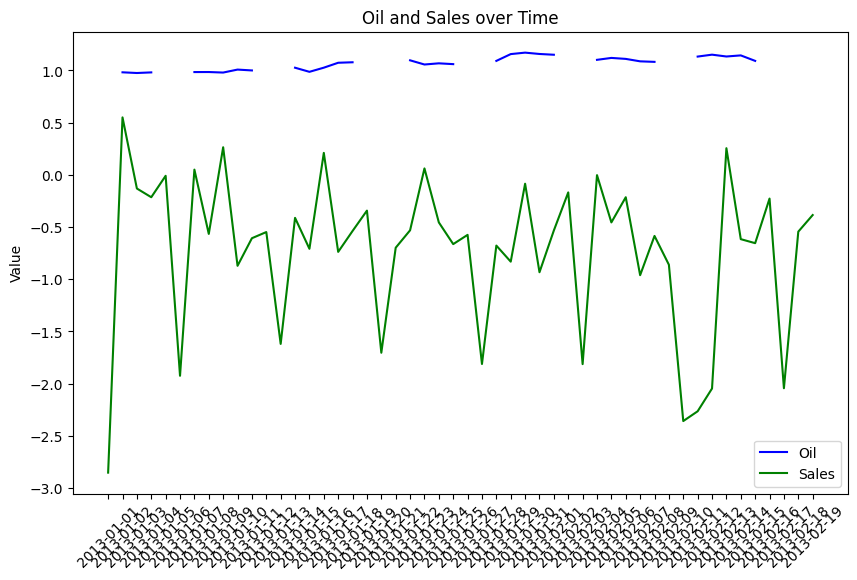

In [187]:
import matplotlib.pyplot as plt

df=df[:50]
# Assuming 'df' is your DataFrame with columns 'date', 'oil', and 'sales'
plt.figure(figsize=(10, 6))

# Plot the 'oil' column with 'date' as the x-axis
plt.plot(df['date'], df['oil'], label='Oil', color='blue')

# Plot the 'sales' column with 'date' as the x-axis
plt.plot(df['date'], df['sales'], label='Sales', color='green')

# Add labels and title
 
plt.ylabel('Value')
plt.title('Oil and Sales over Time')
plt.legend()

# Rotate date labels if needed for readability
plt.xticks(rotation=45)

# Display the plot
plt.show()

In [5]:
# Create an empty dictionary to store the correlation results
lag_correlations = {}
combined_v3=combined
df=combined_v3[(combined_v3['family']=='GROCERY I') & (combined_v3['store_nbr']==1)]
# Loop through lags from 1 to 7 days
for lag in range(1, 365):
    # Create the lagged 'oil' column
    df[f'oil_lag_{lag}'] = df['oil'].shift(lag)
    
    # Calculate the correlation between the lagged oil and sales
    correlation = df[['oil_lag_' + str(lag), 'sales']].corr().iloc[0, 1]
    
    # Store the correlation result for the current lag
    lag_correlations[lag] = correlation

# Print the correlation results for each lag
for lag, corr in lag_correlations.items():
    print(f"Correlation between oil lag {lag} and sales: {corr}")

/tmp/ipykernel_30/135144720.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'oil_lag_{lag}'] = df['oil'].shift(lag)
/tmp/ipykernel_30/135144720.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'oil_lag_{lag}'] = df['oil'].shift(lag)
/tmp/ipykernel_30/135144720.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

Correlation between oil lag 1 and sales: -0.43467317187035287
Correlation between oil lag 2 and sales: -0.3035676031676458
Correlation between oil lag 3 and sales: -0.31556608524073027
Correlation between oil lag 4 and sales: -0.30471140011151826
Correlation between oil lag 5 and sales: -0.2894583893340992
Correlation between oil lag 6 and sales: -0.2994353129214196
Correlation between oil lag 7 and sales: -0.4026888151106556
Correlation between oil lag 8 and sales: -0.41639700339007524
Correlation between oil lag 9 and sales: -0.29556102345549545
Correlation between oil lag 10 and sales: -0.315048661891915
Correlation between oil lag 11 and sales: -0.30565550759758336
Correlation between oil lag 12 and sales: -0.2889671104418935
Correlation between oil lag 13 and sales: -0.2946932566071445
Correlation between oil lag 14 and sales: -0.4011878871582985
Correlation between oil lag 15 and sales: -0.40770720005051125
Correlation between oil lag 16 and sales: -0.2939311538828493
Correlation

/tmp/ipykernel_30/135144720.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'oil_lag_{lag}'] = df['oil'].shift(lag)
/tmp/ipykernel_30/135144720.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'oil_lag_{lag}'] = df['oil'].shift(lag)
/tmp/ipykernel_30/135144720.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented f

In [20]:
lag_correlations.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 22

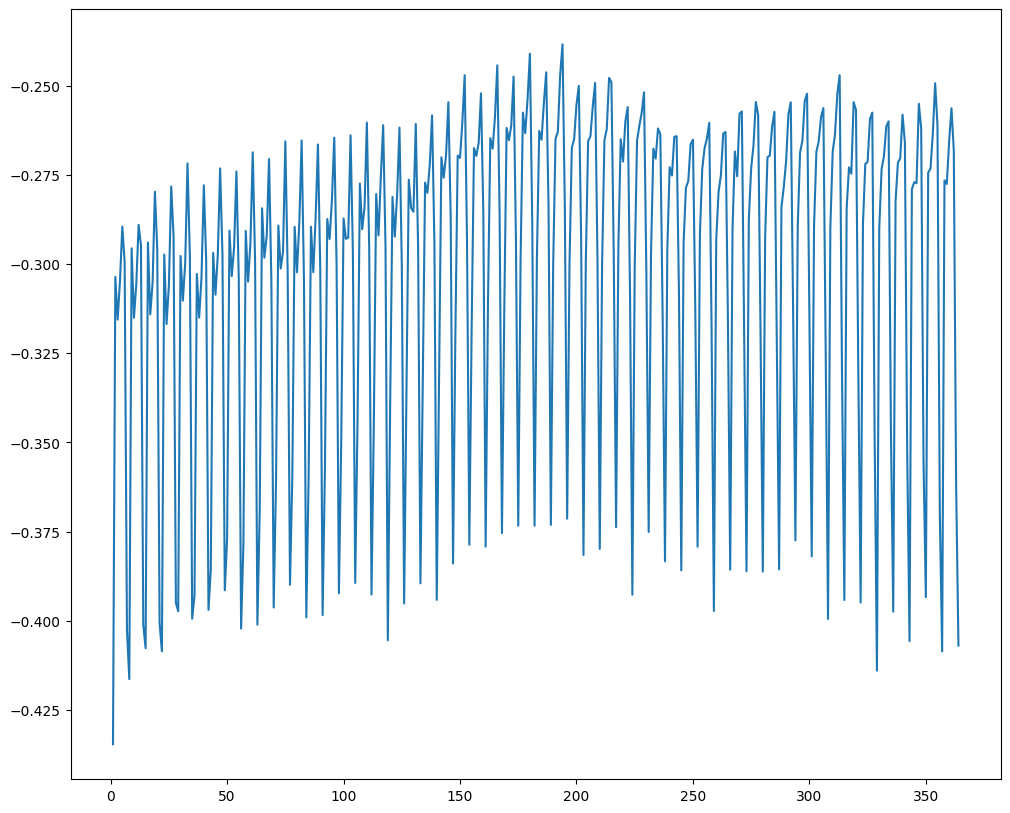

In [26]:
plt.figure(figsize=(12,10))
plt.plot(lag_correlations.keys(),lag_correlations.values())
plt.show()

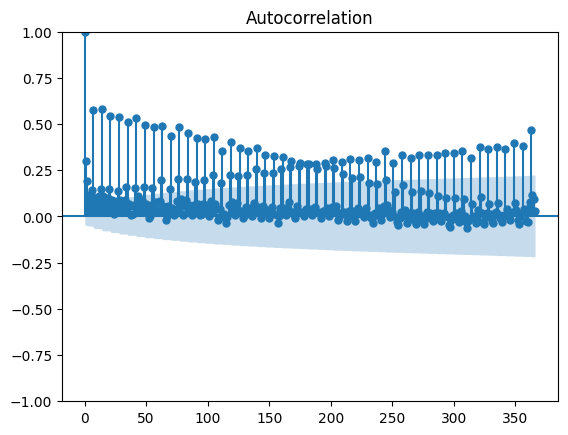

In [27]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Compute the autocorrelation for multiple lags
sm.graphics.tsa.plot_acf(df['sales'], lags=366)  # You can adjust the number of lags
plt.show()

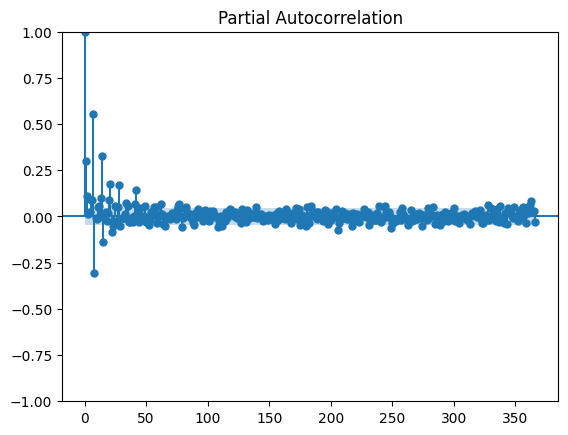

In [28]:
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df['sales'], lags=366)
plt.show()

In [86]:
transact

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
...,...,...,...
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932


In [145]:
combined

,id,date,store_nbr,family,sales,onpromotion,oil,city,state,type_store,cluster,transactions
0,0.0,2013-01-01,1.0,AUTOMOTIVE,0.0,0.0,NaN,Quito,Pichincha,D,13.0,NaN
1,1.0,2013-01-01,1.0,BABY CARE,0.0,0.0,NaN,Quito,Pichincha,D,13.0,NaN
2,2.0,2013-01-01,1.0,BEAUTY,0.0,0.0,NaN,Quito,Pichincha,D,13.0,NaN
3,3.0,2013-01-01,1.0,BEVERAGES,0.0,0.0,NaN,Quito,Pichincha,D,13.0,NaN
4,4.0,2013-01-01,1.0,BOOKS,0.0,0.0,NaN,Quito,Pichincha,D,13.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
3000886,3000754.0,2017-08-15,54.0,SCHOOL AND OFFICE SUPPLIES,0.0,0.0,47.57,El Carmen,Manabi,C,3.0,802.0
3000887,3000755.0,2017-08-15,54.0,SEAFOOD,3.0,0.0,47.57,El Carmen,Manabi,C,3.0,802.0
3000888,NaN,2013-12-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3000889,NaN,2014-12-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [95]:

map1=dict(zip
          (zip(combined['date'],combined['store_nbr']),combined.groupby(['date', 'store_nbr'])['sales'].sum()))

In [96]:
map1

{('2013-01-01', 1.0): 0.0,
 ('2013-01-01', 10.0): 5854.517,
 ('2013-01-01', 11.0): 27612.05095,
 ('2013-01-01', 12.0): 10086.240998,
 ('2013-01-01', 13.0): 17392.097995,
 ('2013-01-01', 14.0): 0.0,
 ('2013-01-01', 15.0): 5694.056,
 ('2013-01-01', 16.0): 22876.474,
 ('2013-01-01', 17.0): 8491.491,
 ('2013-01-01', 18.0): 8414.77698,
 ('2013-01-01', 19.0): 5822.826,
 ('2013-01-01', 2.0): 4233.012,
 ('2013-01-01', 20.0): 10525.460009,
 ('2013-01-01', 21.0): 2059.614998,
 ('2013-01-01', 22.0): 7173.656,
 ('2013-01-01', 23.0): 0.0,
 ('2013-01-01', 24.0): 0.0,
 ('2013-01-01', 25.0): 2898.904,
 ('2013-01-01', 26.0): 5226.362,
 ('2013-01-01', 27.0): 5472.143,
 ('2013-01-01', 28.0): 27715.914,
 ('2013-01-01', 29.0): 8373.67298,
 ('2013-01-01', 3.0): 13860.338,
 ('2013-01-01', 30.0): 0.0,
 ('2013-01-01', 31.0): 4319.945,
 ('2013-01-01', 32.0): 9480.698995,
 ('2013-01-01', 33.0): 4310.253,
 ('2013-01-01', 34.0): 6984.248979999999,
 ('2013-01-01', 35.0): 4518.464004,
 ('2013-01-01', 36.0): 5923.248

In [136]:
transact['transactions']

0         770
1        2111
2        2358
3        3487
4        1922
         ... 
83483    2804
83484    1573
83485    2255
83486     932
83487     802
Name: transactions, Length: 83488, dtype: int64

In [146]:
combined['total_sales_by day']=combined.apply(lambda row: map1.get(row['date'],row['store_nbr']),axis=1)

In [149]:
combined

,id,date,store_nbr,family,sales,onpromotion,oil,city,state,type_store,cluster,transactions,total_sales_by day
0,0.0,2013-01-01,1.0,AUTOMOTIVE,0.0,0.0,NaN,Quito,Pichincha,D,13.0,NaN,1.0
1,1.0,2013-01-01,1.0,BABY CARE,0.0,0.0,NaN,Quito,Pichincha,D,13.0,NaN,1.0
2,2.0,2013-01-01,1.0,BEAUTY,0.0,0.0,NaN,Quito,Pichincha,D,13.0,NaN,1.0
3,3.0,2013-01-01,1.0,BEVERAGES,0.0,0.0,NaN,Quito,Pichincha,D,13.0,NaN,1.0
4,4.0,2013-01-01,1.0,BOOKS,0.0,0.0,NaN,Quito,Pichincha,D,13.0,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000886,3000754.0,2017-08-15,54.0,SCHOOL AND OFFICE SUPPLIES,0.0,0.0,47.57,El Carmen,Manabi,C,3.0,802.0,54.0
3000887,3000755.0,2017-08-15,54.0,SEAFOOD,3.0,0.0,47.57,El Carmen,Manabi,C,3.0,802.0,54.0
3000888,NaN,2013-12-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3000889,NaN,2014-12-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [160]:
result = combined.groupby(['date', 'store_nbr'])['sales'].sum().reset_index()
result=pd.merge(result,transact,on=['date','store_nbr'],how='inner')

In [162]:
result['mean_sales']=result['sales']/result['transactions']

In [172]:
result.iloc[result['mean_sales'].idxmax()]

date            2016-01-02
store_nbr              2.0
sales            16625.706
transactions             6
mean_sales        2770.951
Name: 52392, dtype: object

In [202]:
transact[transact['date']=='2016-01-02']
combined[(combined['date']=='2016-01-02') & (combined['store_nbr']==2) ]
#result[(result['date']=='2016-01-02') & (result['store_nbr']==2) ]

,id,date,store_nbr,family,sales,onpromotion,oil,city,state,type_store,cluster,transactions,total_sales_by day
91641,1948089.0,2016-01-02,2.0,AUTOMOTIVE,9.000,0.0,NaN,Quito,Pichincha,D,13.0,6.0,2.0
91642,1948090.0,2016-01-02,2.0,BABY CARE,0.000,0.0,NaN,Quito,Pichincha,D,13.0,6.0,2.0
91643,1948091.0,2016-01-02,2.0,BEAUTY,2.000,0.0,NaN,Quito,Pichincha,D,13.0,6.0,2.0
91644,1948092.0,2016-01-02,2.0,BEVERAGES,3526.000,4.0,NaN,Quito,Pichincha,D,13.0,6.0,2.0
91645,1948093.0,2016-01-02,2.0,BOOKS,0.000,0.0,NaN,Quito,Pichincha,D,13.0,6.0,2.0
91646,1948094.0,2016-01-02,2.0,BREAD/BAKERY,707.000,0.0,NaN,Quito,Pichincha,D,13.0,6.0,2.0
91647,1948095.0,2016-01-02,2.0,CELEBRATION,9.000,0.0,NaN,Quito,Pichincha,D,13.0,6.0,2.0
91648,1948096.0,2016-01-02,2.0,CLEANING,1134.000,1.0,NaN,Quito,Pichincha,D,13.0,6.0,2.0
91649,1948097.0,2016-01-02,2.0,DAIRY,992.000,9.0,NaN,Quito,Pichincha,D,13.0,6.0,2.0
91650,1948098.0,2016-01-02,2.0,DELI,291.201,0.0,NaN,Quito,Pichincha,D,13.0,6.0,2.0


In [191]:
 

# Drop the row by index
result2 = result[(result['mean_sales']<100) & (result['date']>'2015-01-01') & (result['store_nbr'])<5]

In [198]:
result['mean_sales'].describe()

count    83488.000000
mean         7.463892
std         11.133470
min          1.994896
25%          5.314030
50%          7.156389
75%          9.104670
max       2770.951000
Name: mean_sales, dtype: float64

In [205]:
result['sales'].describe()

count     83488.000000
mean      12831.340052
std        9674.695745
min          26.000000
25%        6477.984753
50%       10015.401998
75%       15703.827000
max      136457.427000
Name: sales, dtype: float64

In [210]:
result[result['sales']>80000]

,date,store_nbr,sales,transactions,mean_sales
57942,2016-04-17,44.0,90557.92509,5242,17.275453
57996,2016-04-18,45.0,114144.37800,3895,29.305360
58130,2016-04-21,20.0,117725.09800,1692,69.577481
58695,2016-05-02,2.0,136457.42700,1905,71.631195
66753,2016-10-02,44.0,84398.82600,5674,14.874661
67003,2016-10-07,39.0,102862.54100,1295,79.430534
68913,2016-11-13,44.0,81774.11500,5690,14.371549
71435,2017-01-02,44.0,83303.56000,5701,14.612096
71436,2017-01-02,45.0,85354.27401,5218,16.357661
76152,2017-04-01,44.0,88183.51200,5827,15.133604


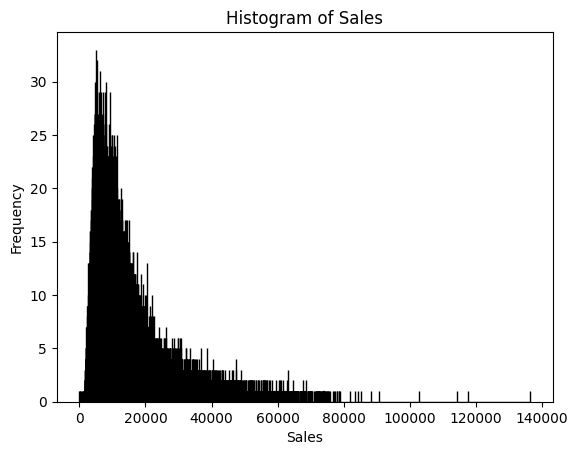

In [211]:
import matplotlib.pyplot as plt

# Create a histogram with 50,000 bins
plt.hist(result['sales'], bins=50000, edgecolor='black')

# Add title and labels to the plot
plt.title('Histogram of Sales')
plt.xlabel('Sales')
plt.ylabel('Frequency')

# Show the plot
plt.show()

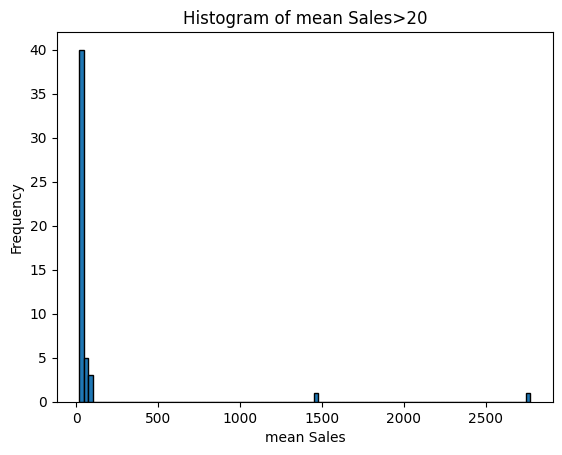

In [231]:
import matplotlib.pyplot as plt
result3=result[result['mean_sales']>20]
# Create a histogram with 50,000 bins
plt.hist(result3['mean_sales'], bins=100, edgecolor='black')

# Add title and labels to the plot
plt.title('Histogram of mean Sales>20')
plt.xlabel('mean Sales')
plt.ylabel('Frequency')

# Show the plot
plt.show()

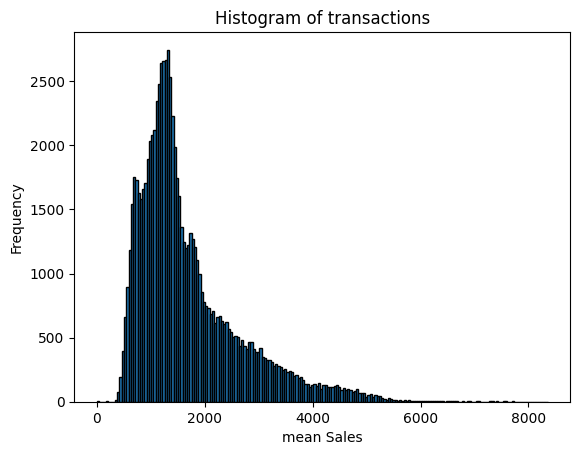

In [232]:
import matplotlib.pyplot as plt

# Create a histogram with 50,000 bins
plt.hist(result['transactions'], bins=200, edgecolor='black')

# Add title and labels to the plot
plt.title('Histogram of transactions')
plt.xlabel('mean Sales')
plt.ylabel('Frequency')

# Show the plot
plt.show()

In [225]:
result['transactions'].describe()

count    83488.000000
mean      1694.602158
std        963.286644
min          5.000000
25%       1046.000000
50%       1393.000000
75%       2079.000000
max       8359.000000
Name: transactions, dtype: float64

In [204]:
result[result['mean_sales']>50]

,date,store_nbr,sales,transactions,mean_sales
32972,2014-12-08,35.0,50977.86099,624,81.695290
33300,2014-12-15,26.0,43339.48300,700,61.913547
51525,2015-12-14,35.0,45574.54600,594,76.724825
51728,2015-12-18,26.0,43563.03300,684,63.688645
52392,2016-01-02,2.0,16625.70600,6,2770.951000
52428,2016-01-04,1.0,14619.33902,10,1461.933902
58130,2016-04-21,20.0,117725.09800,1692,69.577481
58695,2016-05-02,2.0,136457.42700,1905,71.631195
67003,2016-10-07,39.0,102862.54100,1295,79.430534
70418,2016-12-12,35.0,36463.25400,654,55.754211


In [238]:
for i in result[result['sales']>80000]['date'].unique():

    print( hol[hol['date']==i][['locale','description']])

       locale         description
220  National  Terremoto Manabi+1
       locale         description
221  National  Terremoto Manabi+2
       locale                description
224     Local  Cantonizacion de Riobamba
225  National         Terremoto Manabi+5
       locale          description
237  National  Terremoto Manabi+16
Empty DataFrame
Columns: [locale, description]
Index: []
    locale               description
273  Local  Cantonizacion de Quevedo
Empty DataFrame
Columns: [locale, description]
Index: []
       locale                  description
298  National  Traslado Primer dia del ano
       locale                    description
302  Regional  Provincializacion de Cotopaxi


In [239]:
for i in result[result['mean_sales']>50]['date'].unique():

    print( hol[hol['date']==i][['locale','description']])

    locale        description
148  Local  Fundacion de Loja
Empty DataFrame
Columns: [locale, description]
Index: []
Empty DataFrame
Columns: [locale, description]
Index: []
Empty DataFrame
Columns: [locale, description]
Index: []
Empty DataFrame
Columns: [locale, description]
Index: []
Empty DataFrame
Columns: [locale, description]
Index: []
       locale                description
224     Local  Cantonizacion de Riobamba
225  National         Terremoto Manabi+5
       locale          description
237  National  Terremoto Manabi+16
    locale               description
273  Local  Cantonizacion de Quevedo
Empty DataFrame
Columns: [locale, description]
Index: []


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

<Axes: xlabel='date', ylabel='mean_sales'>

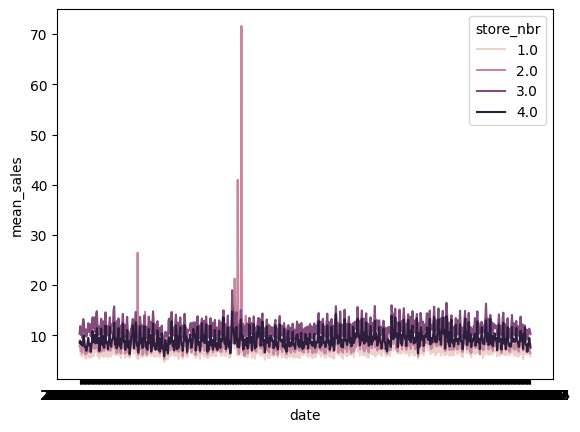

In [194]:
result2 = result[(result['mean_sales']<100) & (result['date']>'2015-08-08') & (result['store_nbr']<5)]
import seaborn as sns
sns.lineplot(data=result2, x='date', y='mean_sales', hue='store_nbr')

In [107]:
transact[(transact['date']=='2013-10-10' )& (transact['store_nbr']==5)]

,date,store_nbr,transactions
13058,2013-10-10,5,1398


In [219]:
combined[(combined['date']=='2016-01-02' )& (combined['store_nbr']==2.0)]

,id,date,store_nbr,family,sales,onpromotion,oil,city,state,type_store,cluster,transactions,total_sales_by day
91641,1948089.0,2016-01-02,2.0,AUTOMOTIVE,9.000,0.0,NaN,Quito,Pichincha,D,13.0,6.0,2.0
91642,1948090.0,2016-01-02,2.0,BABY CARE,0.000,0.0,NaN,Quito,Pichincha,D,13.0,6.0,2.0
91643,1948091.0,2016-01-02,2.0,BEAUTY,2.000,0.0,NaN,Quito,Pichincha,D,13.0,6.0,2.0
91644,1948092.0,2016-01-02,2.0,BEVERAGES,3526.000,4.0,NaN,Quito,Pichincha,D,13.0,6.0,2.0
91645,1948093.0,2016-01-02,2.0,BOOKS,0.000,0.0,NaN,Quito,Pichincha,D,13.0,6.0,2.0
91646,1948094.0,2016-01-02,2.0,BREAD/BAKERY,707.000,0.0,NaN,Quito,Pichincha,D,13.0,6.0,2.0
91647,1948095.0,2016-01-02,2.0,CELEBRATION,9.000,0.0,NaN,Quito,Pichincha,D,13.0,6.0,2.0
91648,1948096.0,2016-01-02,2.0,CLEANING,1134.000,1.0,NaN,Quito,Pichincha,D,13.0,6.0,2.0
91649,1948097.0,2016-01-02,2.0,DAIRY,992.000,9.0,NaN,Quito,Pichincha,D,13.0,6.0,2.0
91650,1948098.0,2016-01-02,2.0,DELI,291.201,0.0,NaN,Quito,Pichincha,D,13.0,6.0,2.0


In [224]:
for i in combined['family'].unique():
    print(' The statistic for', i, 'is', combined[combined['family']==i]['sales'].describe())

 The statistic for AUTOMOTIVE is count    90936.000000
mean         6.101236
std          6.191691
min          0.000000
25%          2.000000
50%          5.000000
75%          8.000000
max        255.000000
Name: sales, dtype: float64
 The statistic for BABY CARE is count    90936.000000
mean         0.110528
std          0.681064
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        116.000000
Name: sales, dtype: float64
 The statistic for BEAUTY is count    90936.000000
mean         3.715723
std          4.794668
min          0.000000
25%          0.000000
50%          2.000000
75%          5.000000
max        136.000000
Name: sales, dtype: float64
 The statistic for BEVERAGES is count    90936.000000
mean      2385.793151
std       2307.882305
min          0.000000
25%        897.000000
50%       1784.000000
75%       3119.000000
max      25413.000000
Name: sales, dtype: float64
 The statistic for BOOKS is count    90936.000000
mean    

## Cheking the type of store:

In [ ]:
 for typ in  set(combined['type_store']):
    filtered_df=combined.loc[combined['type_store']==typ][['family','sales']]
    family_sales = filtered_df.groupby('family')['sales'].sum().astype(int)
    top_3=family_sales.sort_values(ascending=False)[:3]
    print('Type= ',typ,'\n top 3=', top_3,'\n')

### Clusters 



In [ ]:
combined.columns 

In [ ]:
(combined['store_nbr'].unique(),combined['cluster'].unique(),combined[ 'city'].unique())

In [ ]:
for clust in combined['cluster'].unique():
    print( 'In cluster',clust, 'there are the following cities: ', combined[combined['cluster']==clust]['city'].unique())

### Feature importance


In [ ]:
combined.columns.drop(['sales','date', 'year', 'month', 'week_number', 'day'])
combined_encoded = pd.get_dummies(combined, columns=['store_nbr','day_of_the_week', 'city', 'state', 'type_store',
       'family',  'type_hol'])

In [ ]:
combined_encoded=combined_encoded.fillna(0)
Groc_1=combined_encoded[combined_encoded['family_GROCERY I']]
bevar=combined_encoded[combined_encoded['family_BEVERAGES']]
clean=combined_encoded[combined_encoded['family_CLEANING']]

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor  # For classification
from sklearn.model_selection import train_test_split
 
X = Groc_1.drop(['sales','transactions','date', 'year', 'month', 'week_number', 'day'], axis=1) 
y = Groc_1['sales'].fillna(0)

model = RandomForestRegressor(random_state=42)
model.fit(X,y)

feature_importances = model.feature_importances_
feature_names = X.columns

# Create a DataFrame for better readability
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor  # For classification
from sklearn.model_selection import train_test_split
 
X = bevar.drop(['sales','transactions','date', 'year', 'month', 'week_number', 'day'], axis=1) 
y = bevar['sales'].fillna(0)

model = RandomForestRegressor(random_state=42)
model.fit(X,y)

feature_importances = model.feature_importances_
feature_names = X.columns

# Create a DataFrame for better readability
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor  # For classification
from sklearn.model_selection import train_test_split
 
X = clean.drop(['sales','transactions','date', 'year', 'month', 'week_number', 'day'], axis=1) 
y = clean['sales'].fillna(0)

model = RandomForestRegressor(random_state=42)
model.fit(X,y)

feature_importances = model.feature_importances_
feature_names = X.columns

# Create a DataFrame for better readability
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)

### Random forest submission





In [ ]:
df_train_simple=df_train[['date','store_nbr',	'family',	'onpromotion','sales']]
df_train_simple=pd.merge(df_train_simple,oil, on= 'date',how='left')
df_train_simple=pd.get_dummies(df_train_simple, columns=['family','store_nbr'])
df_train_simple['date'] = pd.to_datetime(df_train_simple['date'])
df_train_simple=df_train_simple[df_train_simple['date']>'2017-01-01']
 

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Define features and target
X = df_train_simple.drop(['sales','date'], axis=1).fillna(0)
y = df_train_simple['sales'].fillna(0)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)



# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate accuracy metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)  # Root Mean Squared Error

print("\nMean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)

In [ ]:
from sklearn.metrics import mean_squared_log_error

def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

print("Root Mean Squared log Error:", rmsle(y_test, y_pred))

In [ ]:
df_test

In [ ]:
df_test1=pd.merge(df_test,oil,on='date',how='left').fillna(0)

In [ ]:
dftest1=pd.get_dummies(df_test1, columns=['family','store_nbr'])

In [ ]:
Test_pred = model.predict(dftest1.drop(['id','date'], axis=1))
Test_pred

In [ ]:
sample_subm['sales']=Test_pred
sample_subm

In [ ]:
sample_subm.to_csv('/kaggle/working/submission.csv',index=False)   

### Geopandas


In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Load Ecuador boundary or province shapefile
ecuador = gpd.read_file('/kaggle/input/states-map/ne_10m_admin_1_states_provinces.shp')

In [ ]:
set(combined['city'])

In [ ]:
# Data for Ecuadorian cities with their latitude and longitude
data = {
    'city': [
        'Ambato', 'Babahoyo', 'Cayambe', 'Cuenca', 'Daule', 'El Carmen',
        'Esmeraldas', 'Guaranda', 'Guayaquil', 'Ibarra', 'Latacunga', 'Libertad',
        'Loja', 'Machala', 'Manta', 'Playas', 'Puyo', 'Quevedo', 'Quito', 
        'Riobamba', 'Salinas', 'Santo Domingo'
    ],
    'latitude': [
        -1.2417, -1.8019, 0.0409, -2.9006, -1.8617, -0.3686, 0.9592,
        -1.5933, -2.1700, 0.3517, -0.9352, -2.2333, -3.9931, -3.2586,
        -0.9621, -2.6336, -1.4921, -1.0132, -0.2299, -1.6635, -2.2144,
        -0.2547
    ],
    'longitude': [
        -78.6197, -79.5344, -78.1451, -79.0045, -79.9777, -79.4447, -79.6517,
        -79.0017, -79.9224, -78.1223, -78.6099, -80.9000, -79.2042, -79.9600,
        -80.7127, -80.3898, -77.9853, -79.4608, -78.5249, -78.6546, -80.9582,
        -79.1754
    ]
}

# Create a DataFrame from the data dictionary
gf = pd.DataFrame(data)

# Convert DataFrame to GeoDataFrame using the latitude and longitude columns
geol = gpd.GeoDataFrame(gf, geometry=gpd.points_from_xy(gf['longitude'], gf['latitude']))

# Set the coordinate reference system (CRS) to WGS84 (EPSG:4326), typical for latitude and longitude
geol.set_crs(epsg=4326, inplace=True)

# Display the GeoDataFrame
print(geol)

In [ ]:
 
# Plotting with Cartopy
fig, ax = plt.subplots(figsize=(11, 11), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-82, -77.5, -4.5, 1.5])  # Set extent for Ecuador, make sure values are reasonable

# Plot Ecuador provinces
ecuador.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=1)

# Plot cities
geol.plot(ax=ax, color='red', marker='o', markersize=50, label='Cities', zorder=5)

# Add city names for better visualization
for x, y, label in zip(geol.geometry.x, geol.geometry.y, geol['city']):
    ax.text(x, y, label, fontsize=8, ha='right', color='black')

plt.title('Map of Ecuadorian Cities')
plt.legend()
plt.show()

In [ ]:
kaggle competitions submit -c store-sales-time-series-forecasting -f submission.csv -m "Message"